<a href="https://colab.research.google.com/github/Bryan-Az/Adv-Keras-NNs/blob/main/Part1/Tabular-Model/Augment_Regularization_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An AB Test of Augmented Data and Regularizations


# Imports

In [ ]:
# time-series data augmentation for numeric data
!pip install tsaug
import tsaug
import numpy as np
from tsaug.visualization import plot

# model creation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Creating Augmented Data using Environmental Data Distributions

# Loading and Processing Numerical Features
This will help when processing with the regression model. This data was previously processed in my 'Keras-HF-FastAi' repository when preparing it to be used with the HuggingFace pre-trained "Tabular Question Answering" M.L model. During an earlier processing step when preparing the data for training with FastAi API model-training data loader methods and Sci-kit Learn's "AdaBoostRegressor" model, it was noticed that the data performed better in regression when the original features like working_capacity, fish_production, crop_production_capacity, etc were split into its tuple components, versus when the tuple components were merged into a single feature. This may be due to each component (feature_1, feature_2, etc.) representing a distinct latent variable. For further information for how the data was processed, refert to my 'Keras-HF-FastAi' repository.

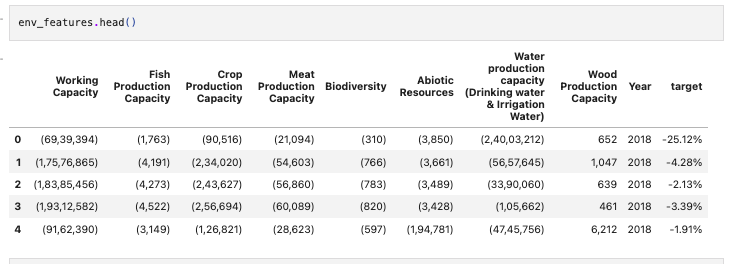

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# importing the file into the environment using google drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname_link_gdrive = {'corp_safeguard_split.csv':'https://drive.google.com/file/d/1mj0mWTZkmrmfD3ItSYrCrf6wGOBkEtau/view?usp=drive_link'}

In [ ]:
csv_name = list(fname_link_gdrive.keys())[0]
id = fname_link_gdrive[csv_name].split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(csv_name)

In [ ]:
environmental_data = pd.read_csv('corp_safeguard_split.csv')

In [ ]:
environmental_data.head()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,...,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,Year,Company Name,target
0,69,39,394.0,445.799955,1,763.0,90,516.0,437.036571,21,...,310,418.64977,3.0,850.0,2,40.0,3.0,2018,APPLUS SERVICES SA,-0.2512
1,1,75,76.0,865.000000,4,191.0,2,34.0,20.000000,54,...,766,418.64977,3.0,661.0,56,57.0,645.0,2018,TELEPERFORMANCE SE,-0.0428
2,1,83,85.0,456.000000,4,273.0,2,43.0,627.000000,56,...,783,418.64977,3.0,489.0,33,90.0,60.0,2018,SGS SA,-0.0213
3,1,93,12.0,582.000000,4,522.0,2,56.0,694.000000,60,...,820,418.64977,3.0,428.0,1,5.0,662.0,2018,INTERTEK GROUP PLC,-0.0339
4,91,62,390.0,445.799955,3,149.0,1,26.0,821.000000,28,...,597,418.64977,1.0,94.0,47,45.0,756.0,2018,THOMSON REUTERS CORP,-0.0191


## Feature Selection for Modelling and Augmentation of the Time Series Feature Distributions
In the Numpy notebook, exploratory data analysis was used to find 2-3 features within the data that would be good choices to non linear regression. In this section, a similar method will be used to apply non-linear regression using Tensorflow low-level functionality that also allows for the creation of a regression model in an object-oriented fashion. For the generation of the synthetic distributions, we need to identify the distribution type and the distribution parameters within the base data, as each variable feature has different distribution characteristics.

### Identifying the distributions & the distribution parameters

In [ ]:
numerical_features = environmental_data.drop(['Company Name'], axis=1)

In this notebook, I will be using the same 3 features (+ the target) identified using the boxplot in the numpy notebook to generate the synthetic distributions. This time, I will be plotting the results in a 4D-plot. I am filtering the data to remove outliers and selecting the 5 most recent years.

In [ ]:
numerical_features.shape

(13177, 20)

In [ ]:
most_recent_year = numerical_features['Year'].max()

# Select rows that are within the 5 most recent years
recent_features = numerical_features[numerical_features['Year'] > most_recent_year - 5]

In [ ]:
year_column = numerical_features['Year']

In [ ]:
recent_features = recent_features.drop('Year', axis=1) # dropping year as it is not a environmental signal

In [ ]:
means = recent_features.mean()
stds = recent_features.std()

# Calculate ymin and ymax for each column
ymins = means - 3 * stds
ymaxs = means + 3 * stds

# Filtering the DataFrame to only include values within ymin and ymax for each column
filtered_numerical_features = recent_features[(recent_features >= ymins) & (recent_features <= ymaxs)].dropna()

In [ ]:
print(numerical_features.shape)
print(filtered_numerical_features.shape)

(13177, 20)
(6557, 19)


In [ ]:
filtered_numerical_features.describe()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,meat_production_capacity_1,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,target
count,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000
mean,20.038585,47.946317,166.746314,443.951521,55.387067,404.281205,19.543389,140.833350,436.210039,21.488181,257.649295,138.462102,420.556388,50.673241,353.629845,20.977429,99.035405,328.361269,-1.143813
std,25.243661,28.918262,249.319003,266.964169,129.647023,298.084564,24.676803,221.374304,271.516195,28.661700,300.369591,226.135342,239.393191,117.611291,295.907676,24.889863,156.221839,293.447537,5.008250
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-97.108400
25%,3.000000,23.000000,32.000000,240.000000,3.000000,103.000000,3.000000,27.000000,214.000000,2.000000,38.000000,2.000000,276.000000,3.000000,73.000000,3.000000,26.000000,65.000000,-0.511900
50%,8.000000,47.000000,65.000000,445.799955,9.000000,400.997112,8.000000,57.000000,437.036571,9.000000,83.000000,14.000000,418.649770,10.000000,357.948948,10.000000,53.000000,322.000000,-0.105000
75%,27.000000,73.000000,97.000000,614.000000,31.000000,649.000000,26.000000,92.000000,617.000000,32.000000,457.000000,197.000000,505.000000,35.000000,576.000000,32.000000,84.000000,534.000000,-0.028000
max,97.000000,185.000000,999.000000,999.000000,706.000000,999.000000,141.000000,957.000000,999.000000,382.000000,999.000000,887.000000,999.000000,694.000000,999.000000,99.000000,808.000000,999.000000,44.022300


## Creating a mask on the timeseries for plotting regions of interest before and after augmentation


In [ ]:
filtered_numerical_features['Year'] = year_column

In [ ]:
filtered_numerical_features.sort_values(by='Year', inplace=True)

In [ ]:
#segmentation mask of it selects areas within the last 7 years
year_recent_mask = filtered_numerical_features['Year'] > 2017.0

In [ ]:
# segmentation mask of biodiversity_0 for use with the tsaug visualization.plot function - it selects areas where the distribution is <300 (to the left of the tail) in numpy
biodiversity_0_mask = filtered_numerical_features['biodiversity_0'] < 300.0

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

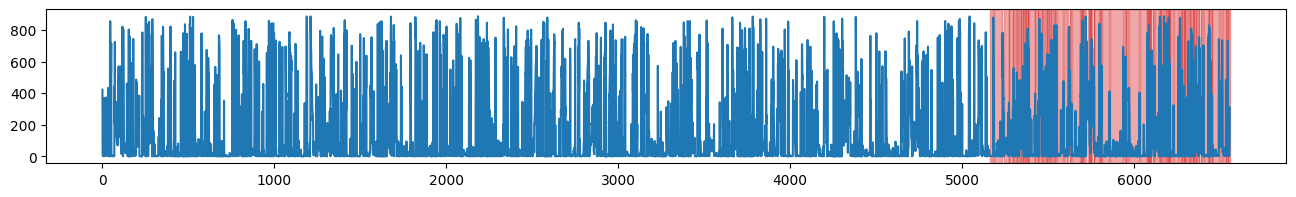

In [ ]:
plot(filtered_numerical_features.loc[:, 'biodiversity_0'].to_numpy(),  biodiversity_0_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
# helps visualize the spike that is seen on the feature distribution in time - - it selects the area to the left of the spike near 400
biodiversity_1_mask_1 = filtered_numerical_features['biodiversity_1'] < 400.0
biodiversity_1_mask = biodiversity_1_mask_1

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

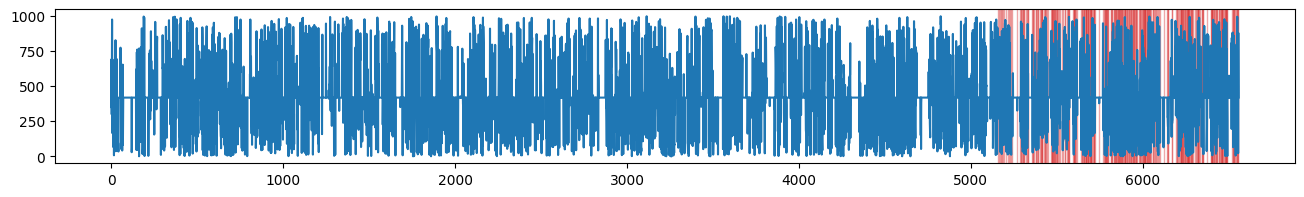

In [ ]:
plot(filtered_numerical_features.loc[:, 'biodiversity_1'].to_numpy(), biodiversity_1_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
#segmentation mask of working_capacity_3 - it selects the area to the left of the spike near 400
working_capacity_3_mask = filtered_numerical_features['working_capacity_3'] < 400.0

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

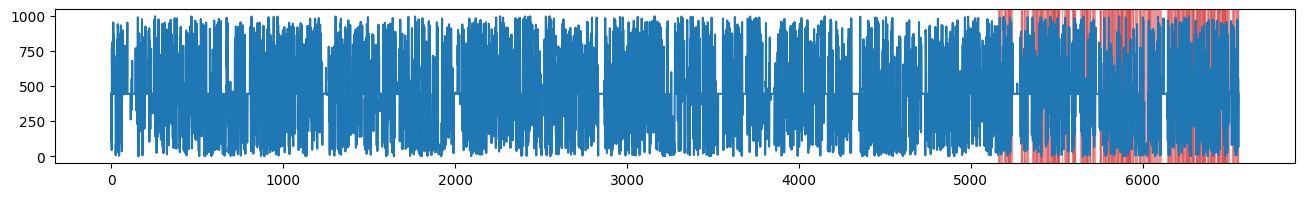

In [ ]:
plot(filtered_numerical_features.loc[:, 'working_capacity_3'].to_numpy(), working_capacity_3_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
#segmentation mask of target - it selects areas in the range -0.511 to 0.64
target_mask = (filtered_numerical_features['target'] > -80) & (filtered_numerical_features['target'] < 40)

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

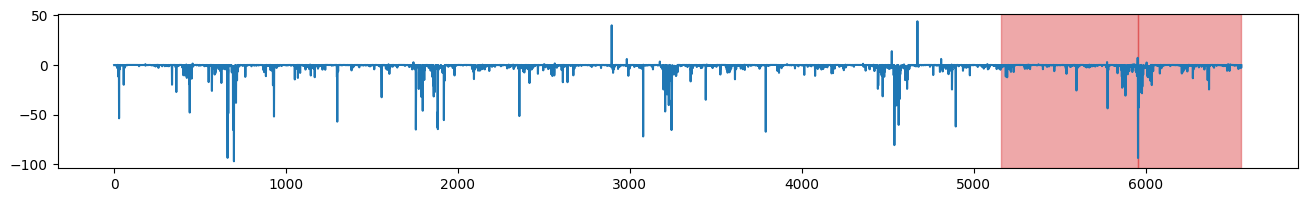

In [ ]:
plot(filtered_numerical_features.loc[:, 'target'].to_numpy(), target_mask.to_numpy() & year_recent_mask.to_numpy())

In [ ]:
X = filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3']].copy(deep=True)

In [ ]:
y = filtered_numerical_features.loc[:, 'target'].copy(deep=True)

In [ ]:
def plot_4d(x, y, z, c, title='4D Plot'):
    """ This function plots the 3 X variables
    as points, and uses color to visualize the target variable.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Assuming x, y, z, and c are numpy arrays or lists of the same length
    # x, y, and z are the coordinates, and c is the color dimension
    ax.scatter(x, y, z, c=c, cmap=plt.hot())

    # Add a colorbar to represent the fourth dimension
    fig.colorbar(ax.scatter(x, y, z, c=c, cmap=plt.hot()),ax=ax, label='Environmental Cost Intensity (%)')

    plt.title(title)
    plt.show()

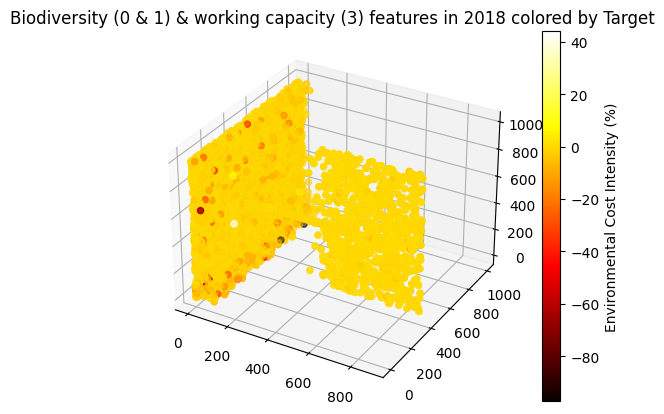

In [ ]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], y, title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')

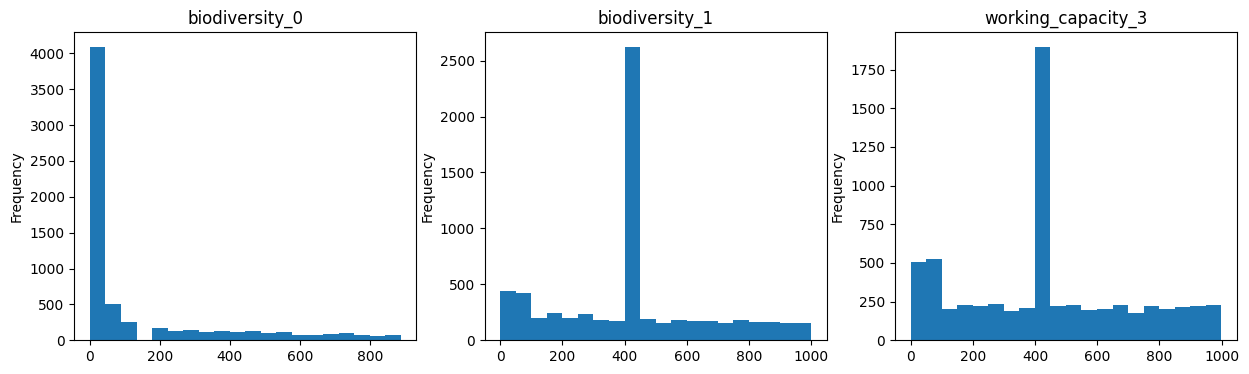

In [ ]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(3 * 5, 4))

# Flatten the array of axes (subplots) for easy iteration
axs_flat = axs.flatten()

for i, column in enumerate(X.columns):
    # Plot the column data in its own subplot
    filtered_numerical_features[column].plot(kind='hist', bins=20, ax=axs_flat[i])
    axs_flat[i].set_title(column)

<Axes: ylabel='Frequency'>

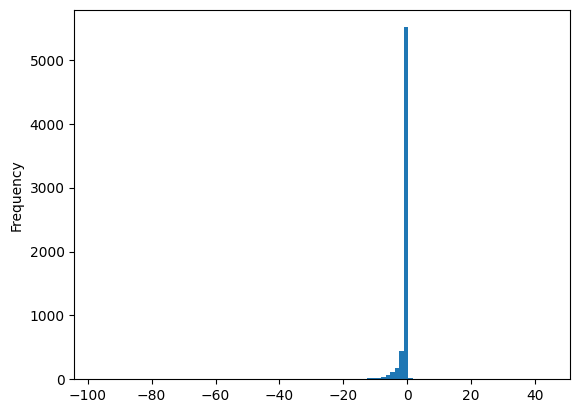

In [ ]:
y.plot(kind='hist', bins=100)

Thoughts on the underlying distributions based on the histograms:
1. The biodiversity_0 feature may be an inverse exponential distribution.
2. The biodiversity_1 feature may be an irregular gaussian as there is a spike near 400.
3. The working_capacity_3 feature may also be an irregular gaussian as there is a spike near 400.
4. The target (environmental cost intensity) feature may be an exponential distribution shifted to the left.

Further hypothesis testing may be done to uncover the underlying distributions generating the data, however, for the purposes of this assignment I will continue by generating the data based on these assumptions.

### Generating the Augmented Data
I'll be applying TSAug to hopefully create a dataset having augmented data based on an estimation of the underlying time series distribution of the three selected variables.

We noticed that the visualization of the features in time looks much different than the visualization of the features without the time variable - this is a tricky distribution and hopefully TSAug can create augmented data that complements this data and is similar in distribution for testing and experimentation with our model.

In [ ]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

In [ ]:
env_data_tsaug = (
    Crop(size=2000) # create a subset augmented set of size n
    + Quantize(n_levels=[10,20,30]) # random quantization level sets
    + Drift(max_drift=(0.01,0.02)) @ 0.8 # randomly drift the data up by 1-2%
    + Reverse() @ 0.5 # randomly reverse the pattern 50% of the time
)

In [ ]:
biodiv0_aug, y_biodiv0_aug = env_data_tsaug.augment(filtered_numerical_features['biodiversity_0'].to_numpy(), biodiversity_0_mask.to_numpy() & year_recent_mask.to_numpy())
biodiv1_aug, y_biodiv1_aug = env_data_tsaug.augment(filtered_numerical_features['biodiversity_1'].to_numpy(), biodiversity_1_mask.to_numpy())
working_aug, y_working_aug = env_data_tsaug.augment(filtered_numerical_features['working_capacity_3'].to_numpy(), working_capacity_3_mask.to_numpy())
target_aug, y_target_aug = env_data_tsaug.augment(filtered_numerical_features['target'].to_numpy(), target_mask.to_numpy())

## Augmenting the X Features

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

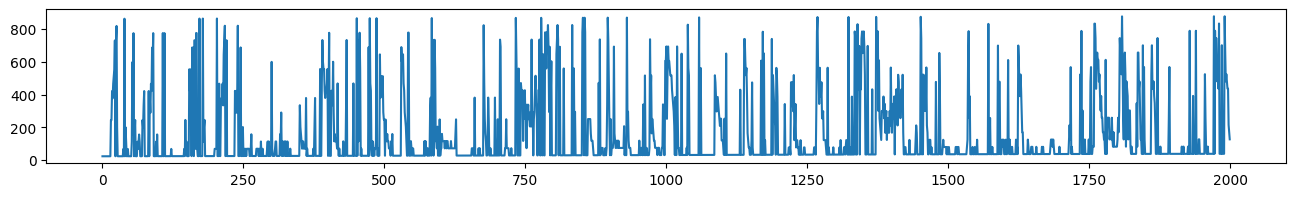

In [ ]:
plot(biodiv0_aug, y_biodiv0_aug) # top plot shows the distribution post augmentation, bottom plot shows the mask to select areas to b

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

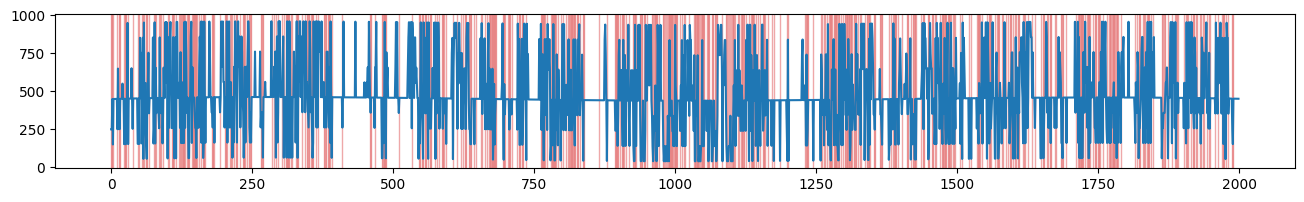

In [ ]:
plot(biodiv1_aug, y_biodiv1_aug)

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

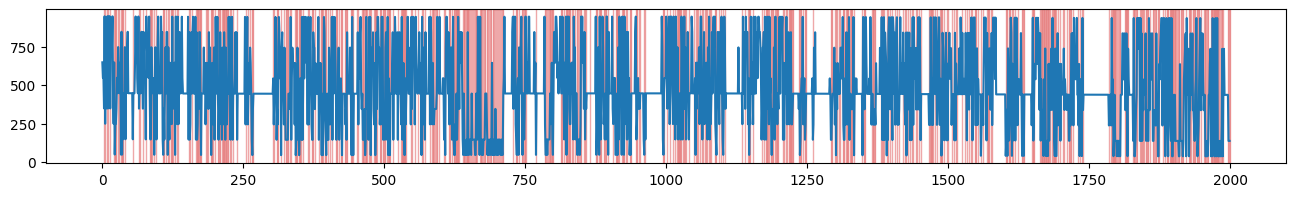

In [ ]:
plot(working_aug, y_working_aug)

## Augmenting the Y Feature

(<Figure size 1600x200 with 1 Axes>, <Axes: >)

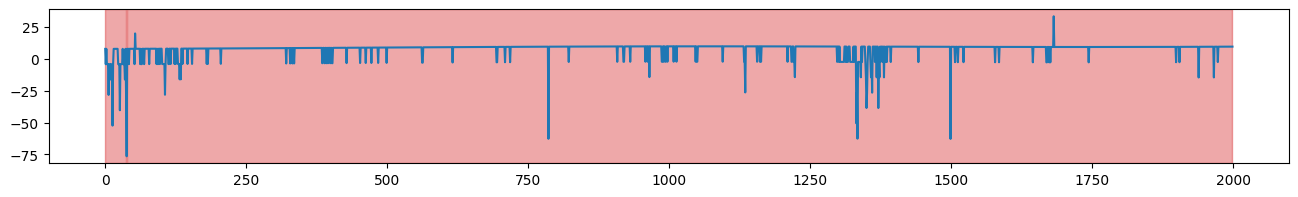

In [ ]:
plot(target_aug, y_target_aug) # as we can see, the target variable is not masked in the areas with the outliers

In [ ]:
# merge biodiv0_aug, biodiv1_aug, and working_aug into a new dataframe with these names for their respective columns
augmented_data = pd.DataFrame({'biodiversity_0': biodiv0_aug, 'biodiversity_1': biodiv1_aug, 'working_capacity_3': working_aug, 'target': target_aug})

The augmented data created with TSAug seems to match some of the key distribution estimators of the original data, such as the standard deviation, mean, and quantiles! This may provide a more fine-grained look at particular sections of the data such as the most recent information and areas of the distribution that are more signal-rich - such as biodiv1 (it has more red due to having a larger mask region).

In [ ]:
filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3', 'target']].describe()

,biodiversity_0,biodiversity_1,working_capacity_3,target
count,6557.000000,6557.000000,6557.000000,6557.000000
mean,138.462102,420.556388,443.951521,-1.143813
std,226.135342,239.393191,266.964169,5.008250
min,1.000000,0.000000,0.000000,-97.108400
25%,2.000000,276.000000,240.000000,-0.511900
50%,14.000000,418.649770,445.799955,-0.105000
75%,197.000000,505.000000,614.000000,-0.028000
max,887.000000,999.000000,999.000000,44.022300


In [ ]:
augmented_data.describe()

,biodiversity_0,biodiversity_1,working_capacity_3,target
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,158.171958,473.653500,476.946953,7.831370
std,217.110368,234.711801,259.894263,6.175392
min,23.100000,39.303063,37.942753,-76.486693
25%,29.535048,355.325717,337.976581,8.727706
50%,37.194527,453.995723,445.538235,9.503905
75%,200.080975,559.181679,645.468633,9.744978
max,877.982168,961.611298,948.937266,33.624040


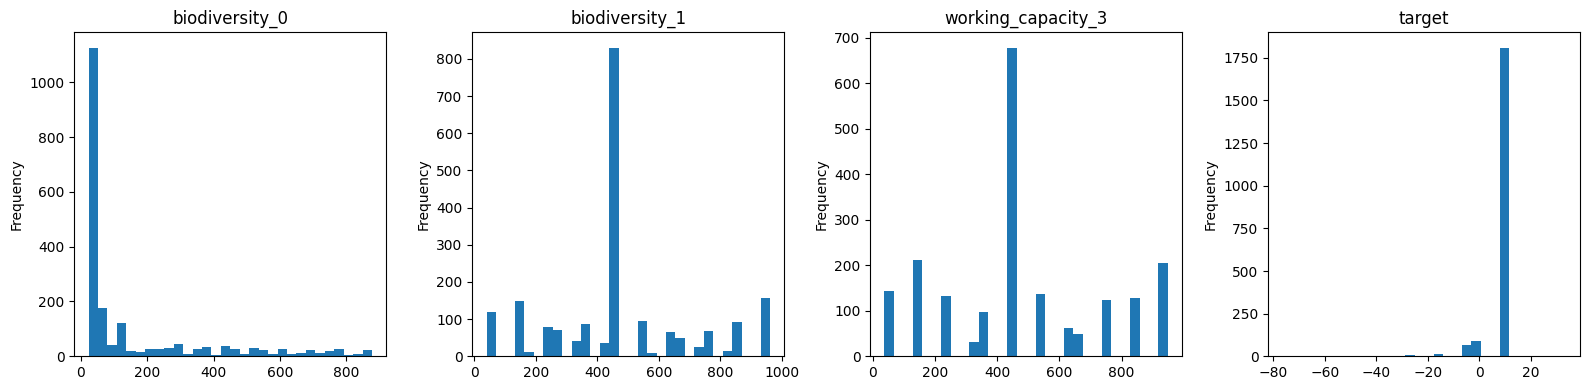

In [ ]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 4))

# Flatten the array of axes (subplots) for easy iteration
axs_flat = axs.flatten()

for i, column in enumerate(augmented_data.columns):
    # Plot the column data in its own subplot
    augmented_data[column].plot(kind='hist', bins=30, ax=axs_flat[i])
    axs_flat[i].set_title(column)
plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

## Scaling the Augmented Numerical Data

In [ ]:
standard_scaler = StandardScaler()
X_scaled=standard_scaler.fit_transform(augmented_data.iloc[:, :-1])

In [ ]:
y_scaled = standard_scaler.fit_transform(augmented_data.iloc[:,-1].to_numpy().reshape(-1, 1))

In [ ]:
print(X_scaled.shape)
print(y_scaled.shape)

(2000, 3)
(2000, 1)


In [ ]:
X_scaled.dtype

dtype('float64')

## Data Transformation

In [ ]:
# using sklearn to split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y_scaled,
                                                    test_size=0.2,
                                                    random_state=88)

In [ ]:
# creating the test/train split
tf_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
tf_test_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# A Tensorflow Model A/B Test of Regularizations
This notebook uses the high-level Keras API, whereas Notebook A uses the low-level sequential API.

## Batch Norm
This model uses the matrix multiply method in the forward pass to update the nodes. 3 variable features will be used in the non linear equation for this 3-layer deep model. Synthetically generated data with 3 variables will be processed with the non-linear equation and plotted using a 4d plot.

In [ ]:
num_inputs = 3
num_outputs = 1
lr = 0.01

#  weight matrix
w_batchnorm = tf.Variable(tf.random.uniform(shape=(num_inputs, num_outputs), dtype=tf.float32), dtype=tf.float32)
# This is our bias vector
b_batchnorm = tf.Variable(tf.zeros(shape=(num_outputs,)), tf.float32)
# Batch normalization layer
batch_norm_layer = tf.keras.layers.BatchNormalization()

def compute_predictions_batchnorm(features):
  features = tf.cast(features, tf.float32)
  features = tf.reshape(features, [-1, 3])
  # Apply batch normalization
  features = batch_norm_layer(features)
  return tf.matmul(features, w_batchnorm) + b_batchnorm

def compute_loss_batchnorm(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch_batchnorm(x, y):
  x = tf.cast(x, tf.float32)
  y = tf.cast(y, tf.float32)
  with tf.GradientTape() as tape:
    predictions = compute_predictions_batchnorm(x)
    loss = compute_loss_batchnorm(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w_batchnorm, b_batchnorm])
  w_batchnorm.assign_sub(lr * dloss_dw)
  b_batchnorm.assign_sub(lr * dloss_db)
  return loss

## L2

In [ ]:
num_inputs = 3
num_outputs = 1
lr = 0.01

#  weight matrix
w_l2 = tf.Variable(tf.random.uniform(shape=(num_inputs, num_outputs), dtype=tf.float32), dtype=tf.float32)
# This is our bias vector
b_l2 = tf.Variable(tf.zeros(shape=(num_outputs,)), tf.float32)

def compute_predictions_l2(features):
  features = tf.cast(features, tf.float32)
  features = tf.reshape(features, [-1, 3])
  return tf.matmul(features, w_l2) + b_l2

def compute_loss_l2(labels, predictions):
  # Calculate the L2 regularization loss
  l2_loss = tf.nn.l2_loss(w_l2)
  # Add the L2 regularization loss to the total loss
  return tf.reduce_mean(tf.square(labels - predictions)) + l2_loss

def train_on_batch_l2(x, y):
  x = tf.cast(x, tf.float32)
  y = tf.cast(y, tf.float32)
  with tf.GradientTape() as tape:
    predictions = compute_predictions_l2(x)
    loss = compute_loss_l2(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w_l2, b_l2])
  w_l2.assign_sub(lr * dloss_dw)
  b_l2.assign_sub(lr * dloss_db)
  return loss

## Montecarlo Dropout

In [ ]:
num_inputs = 3
num_outputs = 1
lr = 0.01

#  weight matrix
w_dropout = tf.Variable(tf.random.uniform(shape=(num_inputs, num_outputs), dtype=tf.float32), dtype=tf.float32)
# This is our bias vector
b_dropout = tf.Variable(tf.zeros(shape=(num_outputs,)), tf.float32)

def compute_predictions_dropout(features):
  features = tf.cast(features, tf.float32)
  features = tf.reshape(features, [-1, 3])
  return tf.matmul(features, w_dropout) + b_dropout

def compute_loss_dropout(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch_dropout(x, y):
  x = tf.cast(x, tf.float32)
  y = tf.cast(y, tf.float32)
  with tf.GradientTape() as tape:
    predictions = compute_predictions_dropout(x)
    loss = compute_loss_dropout(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w_dropout, b_dropout])
  w_dropout.assign_sub(lr * dloss_dw)
  b_dropout.assign_sub(lr * dloss_db)
  return loss

## Training the Models on the Augmented Training Data for Batch Norm and L2 with Earlystop: Validation Loss

The augmented data generated with TSAug seems to perform better than with the samples synthetically generated from eye-balled distribution estimators in within the previous [Tensorflow](https://github.com/Bryan-Az/TF-PyTorch-Jax-NN) notebook. Let's see how it differs when using batchnorm and l2, and using earlstop training on the validation loss metric.

In [ ]:
def train_with_early_stopping(tf_train_dataset, tf_test_dataset, train_function, predict_function, num_epochs=10):
  best_val_metric = float('inf')
  best_epoch = 0
  patience = 3

  for epoch in range(num_epochs):
    for step, (x, y) in enumerate(tf_train_dataset):
      loss = train_function(x, y)
      # Logging.
      if step % 200 == 0:
        print('Step:', step)
        print('Loss from last step: %.3f' % loss)

    # Evaluate the model on the validation set.
    test_predictions = predict_function(tf_test_dataset)
    # set the val_metric to calculate validation loss using predictions and x_test

    def compute_validation_loss(labels, predictions):
      return tf.reduce_mean(tf.keras.losses.mse(labels, predictions))

    val_metric = compute_validation_loss(y_test, test_predictions)

    # Check if the validation metric has improved.
    if val_metric < best_val_metric:
      best_val_metric = val_metric
      best_epoch = epoch
    else:
      # If the validation metric has not improved for 'patience' epochs, stop training.
      if epoch - best_epoch >= patience:
        print('Early stopping at epoch %d.' % epoch)
        break

    print('Epoch %d: last batch valid. loss = %.4f' % (epoch, float(loss)))

  return best_epoch

In [ ]:
train_with_early_stopping(tf_train_dataset, X_test, train_on_batch_batchnorm, compute_predictions_batchnorm, num_epochs=10)

Step: 0
Loss from last step: 0.013
Step: 200
Loss from last step: 0.778
Step: 400
Loss from last step: 0.281
Step: 600
Loss from last step: 0.000
Step: 800
Loss from last step: 0.020
Step: 1000
Loss from last step: 0.043
Step: 1200
Loss from last step: 0.007
Step: 1400
Loss from last step: 2.978
Epoch 0: last batch valid. loss = 0.0001
Step: 0
Loss from last step: 0.000
Step: 200
Loss from last step: 0.818
Step: 400
Loss from last step: 0.281
Step: 600
Loss from last step: 0.000
Step: 800
Loss from last step: 0.020
Step: 1000
Loss from last step: 0.043
Step: 1200
Loss from last step: 0.007
Step: 1400
Loss from last step: 2.978
Epoch 1: last batch valid. loss = 0.0001
Step: 0
Loss from last step: 0.000
Step: 200
Loss from last step: 0.818
Step: 400
Loss from last step: 0.281
Step: 600
Loss from last step: 0.000
Step: 800
Loss from last step: 0.020
Step: 1000
Loss from last step: 0.043
Step: 1200
Loss from last step: 0.007
Step: 1400
Loss from last step: 2.978
Epoch 2: last batch valid. 

0

In [ ]:
train_with_early_stopping(tf_train_dataset, X_test, train_on_batch_l2, compute_predictions_l2, num_epochs=10)

Step: 0
Loss from last step: 0.715
Step: 200
Loss from last step: 0.446
Step: 400
Loss from last step: 0.358
Step: 600
Loss from last step: 0.006
Step: 800
Loss from last step: 0.193
Step: 1000
Loss from last step: 0.045
Step: 1200
Loss from last step: 0.003
Step: 1400
Loss from last step: 3.056
Epoch 0: last batch valid. loss = 0.0022
Step: 0
Loss from last step: 0.005
Step: 200
Loss from last step: 0.449
Step: 400
Loss from last step: 0.358
Step: 600
Loss from last step: 0.006
Step: 800
Loss from last step: 0.193
Step: 1000
Loss from last step: 0.045
Step: 1200
Loss from last step: 0.003
Step: 1400
Loss from last step: 3.056
Epoch 1: last batch valid. loss = 0.0022
Step: 0
Loss from last step: 0.005
Step: 200
Loss from last step: 0.449
Step: 400
Loss from last step: 0.358
Step: 600
Loss from last step: 0.006
Step: 800
Loss from last step: 0.193
Step: 1000
Loss from last step: 0.045
Step: 1200
Loss from last step: 0.003
Step: 1400
Loss from last step: 3.056
Epoch 2: last batch valid. 

0

## Training the Model on the Augmented Training Data for Montecarlo Dropout

In [ ]:
def train_with_early_stopping_montecarlo(tf_train_dataset, tf_test_dataset, train_function, predict_function, num_epochs=10):
  best_val_metric = float('inf')
  best_epoch = 0
  patience = 3

  for epoch in range(num_epochs):
    for step, (x, y) in enumerate(tf_train_dataset):
      loss = train_function(x, y)
      # Logging.
      if step % 200 == 0:
        print('Step:', step)
        print('Loss from last step: %.3f' % loss)

    # Evaluate the model on the validation set.
    # Make multiple predictions for each input during testing
    predictions = []
    for _ in range(10):  # Number of Monte Carlo samples
        predictions.append(predict_function(tf_test_dataset))
    # Average the predictions from each run to get the final prediction
    test_predictions = tf.reduce_mean(predictions, axis=0)


    def compute_validation_loss(labels, predictions):
      return tf.reduce_mean(tf.keras.losses.mse(labels, predictions))

    val_metric = compute_validation_loss(y_test, test_predictions)

    # Check if the validation metric has improved.
    if val_metric < best_val_metric:
      best_val_metric = val_metric
      best_epoch = epoch
    else:
      # If the validation metric has not improved for 'patience' epochs, stop training.
      if epoch - best_epoch >= patience:
        print('Early stopping at epoch %d.' % epoch)
        break

    print('Epoch %d: last batch valid. loss = %.4f' % (epoch, float(loss)))

  return best_epoch

In [ ]:
train_with_early_stopping_montecarlo(tf_train_dataset, X_test, train_on_batch_dropout, compute_predictions_dropout, num_epochs=10)

Step: 0
Loss from last step: 0.015
Step: 200
Loss from last step: 0.778
Step: 400
Loss from last step: 0.281
Step: 600
Loss from last step: 0.000
Step: 800
Loss from last step: 0.020
Step: 1000
Loss from last step: 0.043
Step: 1200
Loss from last step: 0.007
Step: 1400
Loss from last step: 2.978
Epoch 0: last batch valid. loss = 0.0001
Step: 0
Loss from last step: 0.000
Step: 200
Loss from last step: 0.818
Step: 400
Loss from last step: 0.281
Step: 600
Loss from last step: 0.000
Step: 800
Loss from last step: 0.020
Step: 1000
Loss from last step: 0.043
Step: 1200
Loss from last step: 0.007
Step: 1400
Loss from last step: 2.978
Epoch 1: last batch valid. loss = 0.0001
Step: 0
Loss from last step: 0.000
Step: 200
Loss from last step: 0.818
Step: 400
Loss from last step: 0.281
Step: 600
Loss from last step: 0.000
Step: 800
Loss from last step: 0.020
Step: 1000
Loss from last step: 0.043
Step: 1200
Loss from last step: 0.007
Step: 1400
Loss from last step: 2.978
Epoch 2: last batch valid. 

0

# Evaluating a sample Model (BatchNorm) on the Augmented Testing Data

## The Real Data Y 'Truth' Labels

In [ ]:
X = filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3']].copy(deep=True)
y = filtered_numerical_features.loc[:, ['target']].copy(deep=True)

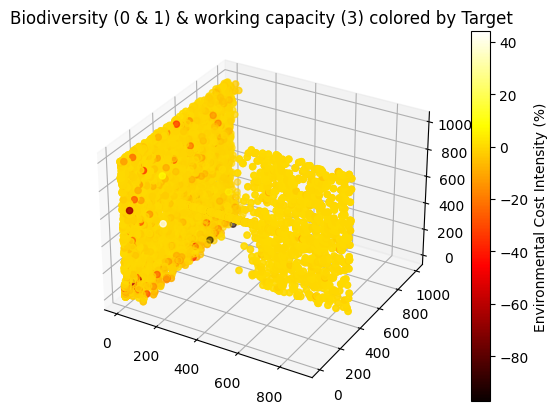

In [ ]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], y, title='Biodiversity (0 & 1) & working capacity (3) colored by Target')

## The Real Data Y 'Prediction' Labels

In [ ]:
predictions = compute_predictions_batchnorm(X)

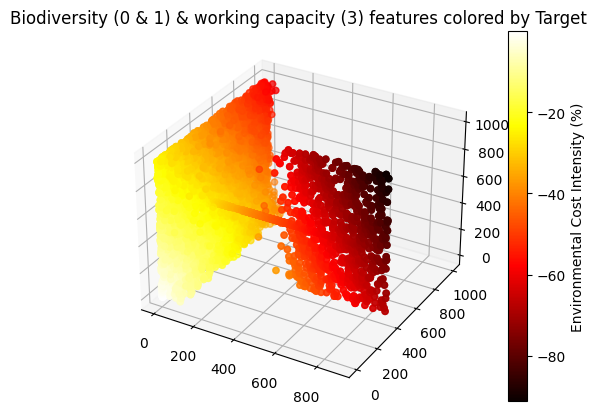

In [ ]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], predictions, title='Biodiversity (0 & 1) & working capacity (3) features colored by Target')

## The Simulated Data Y 'Truth' Labels

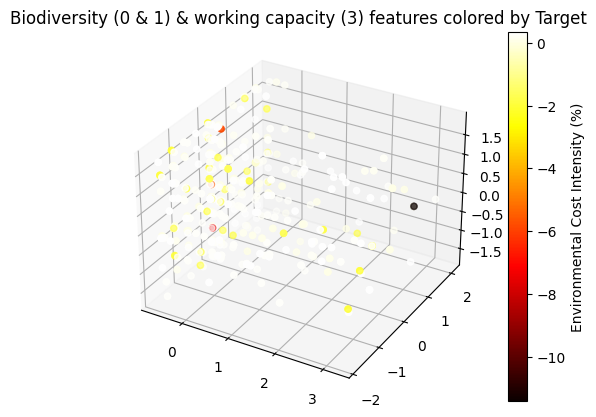

In [ ]:
plot_4d(X_test[:,0], X_test[:,1], X_test[:,2], y_test, title='Biodiversity (0 & 1) & working capacity (3) features colored by Target')

## The Simulated Data Y 'Prediction' Labels

In [ ]:
simulated_test_predictions = compute_predictions_batchnorm(X_test)

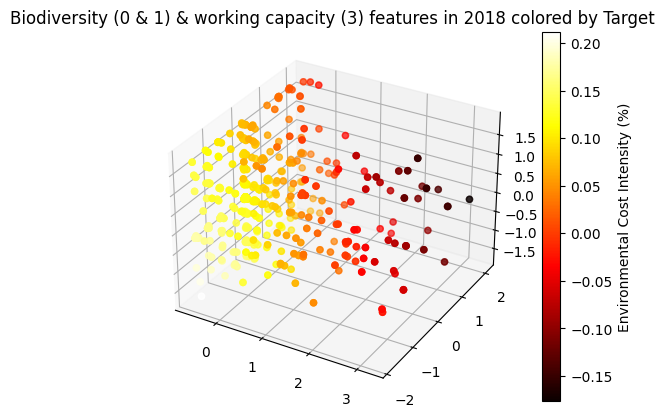

In [ ]:
plot_4d(X_test[:,0], X_test[:,1], X_test[:,2], simulated_test_predictions[:,0], title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')